#### Name: Eric Lindgren
#### CID: ericlin
#### PSN: 970222-1954

## Bayesian Optimization

In [27]:
# Imports
# KEYS
#
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import GPy
from tqdm import tqdm_notebook

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

### Task 1

In [2]:
def true_func(x):
    '''The true function for which we wish to find the min.'''
    return np.sin(6*x) + 0.2*x**2 - 0.7*x


# Tests
print(f'True function passing unit test: {-1.137==np.round(true_func(2),3)}')

True function passing unit test: True


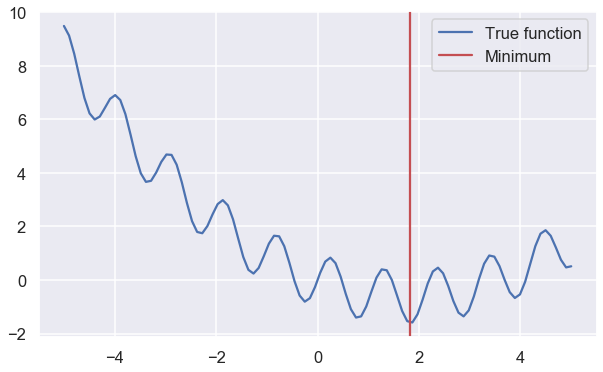

In [3]:
#Plot
x = np.linspace(-5,5,100)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, true_func(x), label='True function')
# The minimum is at around 2
ax.axvline(1.825, color='r', label='Minimum')
plt.legend(loc="best")

In [29]:
# Minimize using scipy.optimize for 100 times

np.random.seed(1)  # Set seed 
nbr_iter = 100  # Number of optimizations
nbr_correct = 0  # Number of ''correct'' optimizations
function_calls = 0  # Total number of function calls
function_calls_correct = []  # An array containing the number of function calls for each succesful termination
x_star = 1.825  # The estimated minimum from the plot above
tol = 0.05  # The range in which we want our solution to get for a successful minimum

# Rename sp.optimize.minimize as minmz
minmz = sp.optimize.minimize

for i in tqdm_notebook(range(nbr_iter)):
    # Draw a random starting point in the interval x \in (-5, 5).
    x_start= np.random.uniform(-5,5)
    # Optimize using Nealder Mead, with a
    opt_results = minmz(fun=true_func, x0=x_start, method='Nelder-Mead', tol=0.01)
    # Check if terminated to x_star
    x_star_opt = opt_results.x
    if np.abs(x_star - x_star_opt) < tol:
        #print(f'Optimization terminated succesfully to {x_star_opt}')
        nbr_correct += 1  # Increase number of correct optimizations
        function_calls_correct.append(opt_results.nit)  # Append number of function calls
    function_calls += opt_results.nit
    
    
# Sanity check
assert nbr_correct == len(function_calls_correct)

# Print results
print(f'Number of succesful terminations: {nbr_correct} out of {nbr_iter}.')
print(f'Total function calls: {function_calls}.')
print(f'Mean of function calls for a correct termination: {np.mean(function_calls_correct):.2f}.')
print(f'Ratio of mean of correct function evaluations and total function calls: {np.mean(function_calls_correct)/function_calls:.3f}.')


Number of succesful terminations: 12 out of 100.
Total function calls: 687.
Mean of function calls for a correct termination: 6.08.
Ratio of mean of correct function evaluations and total function calls: 0.009.


### Task 2

In [14]:
def LCB_fun(x, model):
    '''
    Implements the Lower Confidence Bound (LCB) acquisition function for GP model 'model'.
    Given an input value x, the mean and sigma of the predicted function value is computed 
    and mu-sigma is returned. 
    '''
    if np.abs(x)>5:
        '''If x is outside the allowed interval, return 0'''
        return 0
    X = np.array(x).reshape(1,1)
    mu, var = model.predict(X)  # Predicts the output value for x, and returns the mean and std of that prediction (it's a Gaussian).
    return mu-2*np.sqrt(var)


def optimize_acquisition(x0, model):
    '''Minimizes the acquisiton function given some intial guess x0 and a model.'''
    # Use the same optimizer as for Task 1. 
    minimize_object = minmz(fun=lambda x: LCB_fun(x, model), x0=x0, method='Nelder-Mead', tol=0.01)
    x_argmax = minimize_object.x
    return x_argmax

In [42]:
np.random.seed(1)  # Set seed 
k = 2  # The number of starting points
nbr_iter = 100  # The number of sampling points
X = np.random.uniform(-5,5, k)  # Sample k random starting points in the interval
Y = true_func(X)
# Initialize the data vector 
D = np.row_stack([X,Y]) 


# Define the statistical model, which is a Gaussian defined by a covariance matrix from a GPy covariance function
kernel = GPy.kern.RBF(input_dim=1)  # Use a defualt RBF covariance function, since we have no prior information
D_X = D[:,0].reshape(k,1)  # Reformat X and Y vectors for input into GP model
D_Y = D[:,1].reshape(k,1)  # -||-
model = GPy.models.GPRegression(D_X,D_Y,kernel)
model['rbf.lengthscale'].constrain_bounded(.1,10)  # Constrain the lengthscale of the model so it doesn't get too small
model.optimize()  # Optimize the model to the current data

min_y_values = []  # For plot of y_min as a function of the iteration number
for i in tqdm_notebook(range(k,nbr_iter)):
    # Randomize the starting position
    x_start = np.random.uniform(-5,5, 1)
    # Select x_i by optimizeing the acquisition function
    x_i = optimize_acquisition(x0=x_start, model=model)  # Starting guess is 1
    # Evaluate the objective function for x_i
    y_i = np.array(true_func(x_i)).reshape(1,1)
    # Combine and reshape for data vector
    xy = np.array([x_i, y_i]).T  # Transpose to stack it properly with D
    # Append this to the data vector
    D = np.row_stack([D,xy])
    # Re-optimize the statistical model for the data
    D_X = D[:,0].reshape(len(D),1)  # Reformat X and Y vectors for input into GP model
    D_Y = D[:,1].reshape(len(D),1)  # -||-
    model = GPy.models.GPRegression(D_X,D_Y,kernel)
    model.optimize()  # Re-optimize the model to the current data
    # Extract y_min
    min_idx = D[:,1].argmin()
    y_min = D[min_idx, 1]
    min_y_values.append(y_min)

assert D.shape==(nbr_iter, 2)  # Sanity check

reconstraining parameters GP_regression.rbf.lengthscale


x_min is: 1.834 . Is this within 0.05 of the exact mean? True.


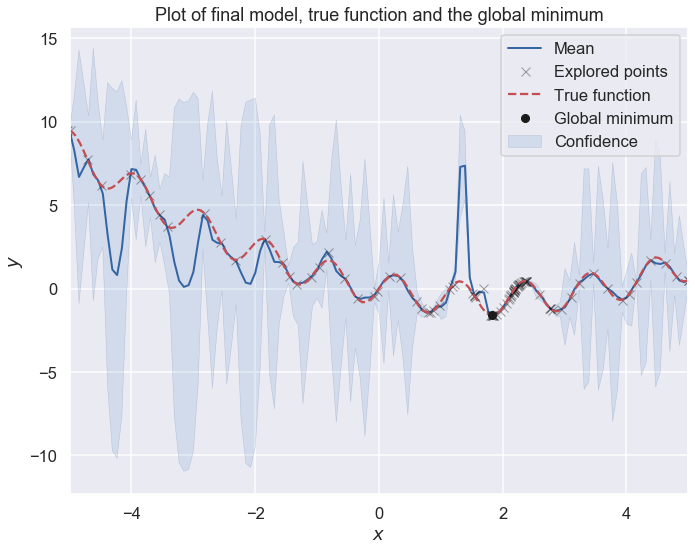

In [52]:
# Find the minimum in the data vector
min_idx = D[:,1].argmin()
x_min = D[min_idx, 0]
y_min = D[min_idx, 1]
print(f'x_min is: {x_min:.3f} . Is this within 0.05 of the exact mean? {np.abs(x_min-x_star) < 0.05}.')

# Plot model with true function
fig, ax = plt.subplots(figsize=(10,8))

model.plot(plot_data=False, ax=ax)
x = np.linspace(-5,5,1000)
ax.plot(D[:,0], D[:,1], 'kx', label='Explored points', alpha=0.4)
ax.plot(x, true_func(x), 'r--', label='True function')
ax.plot(x_min, y_min, 'k.', markersize=16, label='Global minimum')
ax.legend()
ax.set_xlim(-5,5)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.title('Plot of final model, true function and the global minimum')

plt.tight_layout()

Notice that the model uncertainty is very small around the global minimum, while being quite large in other regions. This hints at the region close to the global minimum being quite well explored. This can be seen in the convergenge plot for $y_{min}$; almost all minimum y-values are function values quite close to the global minimum, especially during the latter fraction of the iterations.

Text(0.5, 1.0, '$y_{min}$ as a function of iteration number $n$')

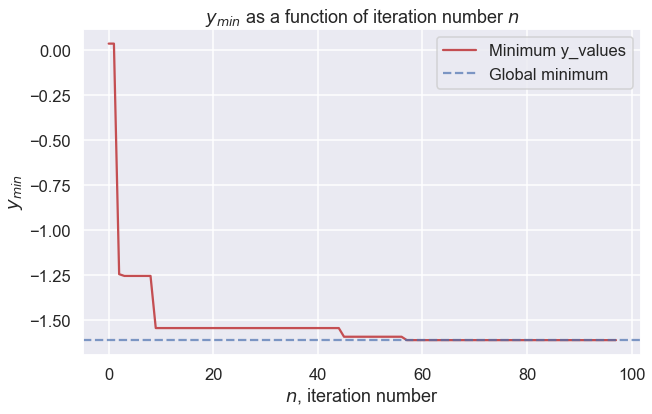

In [50]:
# Plot y_min as a function of iteration number
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(min_y_values, 'r', label="Minimum y_values")
ax.axhline(y_min, linestyle='--', color='b', alpha=0.7, label='Global minimum')
plt.legend(loc='best')
ax.set_xlabel(r'$n$, iteration number')
ax.set_ylabel(r'$y_{min}$')
plt.title(r'$y_{min}$ as a function of iteration number $n$')